In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.utils import np_utils
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation
from tensorflow.keras.models import Sequential

from music21 import converter, instrument, note, chord, stream
import glob

from keras.utils import np_utils

FONTSIZE=18
plt.rcParams['figure.figsize']=(10,6)
plt.rcParams['font.size']=FONTSIZE

Using TensorFlow backend.


# Load in MIDI files and convert them to notes

In [2]:
def read_midi(file):
    notes=[]
    notes_to_parse = None

    #parsing a midi file
    try:
        midi = converter.parse(file)
    except:
        return notes
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)
    
    try:

        #Looping over all the instruments
        for part in s2.parts:
            #select elements of only piano
            if 'Piano' in str(part): 
                notes_to_parse = part.recurse() 
                #finding whether a particular element is note or a chord
                for element in notes_to_parse:
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    elif isinstance(element, chord.Chord):
                        notes.append('.'.join(str(n) for n in element.normalOrder))

        return notes
    
    except: #sometimes a Nonetype object is loaded into parts
        
        return notes

filenames=glob.glob('../MIDI_files/F/F/Final Fantasy*.mid')
print(len(filenames))
notes=[]
notes_per_song=[]

for i in range(len(filenames)):
    print(filenames[i])
    notes_temp=read_midi(filenames[i])
    if len(notes_temp)>1:
        notes.extend(notes_temp)
        notes_per_song.append(len(notes_temp))

218
../MIDI_files/F/F/Final Fantasy VI - The Decisive Battle.mid
../MIDI_files/F/F/Final Fantasy V - The Last Battle.mid
../MIDI_files/F/F/Final Fantasy III - Ancients Village.mid
../MIDI_files/F/F/Final Fantasy IX - Kujas Theme.mid
../MIDI_files/F/F/Final Fantasy X - Suteki Da Ne.mid
../MIDI_files/F/F/Final Fantasy VII - Fighting.mid
../MIDI_files/F/F/Final Fantasy VII - Descandant of the Shinobi.mid
../MIDI_files/F/F/Final Fantasy X-2 - 1000 Words.mid
../MIDI_files/F/F/Final Fantasy I - Main Theme.mid
../MIDI_files/F/F/Final Fantasy VIII - Force Your Way.mid
../MIDI_files/F/F/Final Fantasy VIII - FITHOS LUSEC WECOS VINOSEC.mid
../MIDI_files/F/F/Final Fantasy IV - Rydia - Lydia.mid
../MIDI_files/F/F/Final Fantasy II - Castle Pandemonium.mid
../MIDI_files/F/F/Final Fantasy Crystal Chronicles - River Belle Path.mid
../MIDI_files/F/F/Final Fantasy XI - Sanctuary of Zi'tah.mid
../MIDI_files/F/F/Final Fantasy IV - Golbez Clad in the Darkness.mid
../MIDI_files/F/F/Final Fantasy  - Final Fan

In [3]:
print(len(notes))
print(sum(notes_per_song))
print(notes_per_song) #what we can actually do here is partition by song
#training data will have roughly 75% of songs and validation data will have remaining songs

num_songs=len(notes_per_song)
print(num_songs)

108152
108152
[1155, 1027, 324, 492, 242, 624, 327, 956, 864, 554, 152, 601, 916, 287, 1121, 831, 412, 744, 188, 491, 344, 782, 943, 553, 175, 144, 229, 838, 1182, 509, 3658, 699, 368, 339, 262, 184, 175, 235, 518, 254, 456, 188, 735, 191, 940, 788, 701, 812, 691, 828, 1084, 1665, 413, 318, 259, 286, 427, 537, 301, 205, 128, 730, 551, 73, 574, 512, 534, 1237, 331, 1286, 1084, 303, 186, 395, 501, 170, 752, 337, 833, 128, 73, 416, 523, 1030, 430, 456, 384, 219, 240, 379, 332, 1054, 201, 419, 911, 357, 850, 180, 418, 350, 1080, 1067, 813, 1709, 308, 161, 312, 61, 1108, 188, 440, 393, 212, 366, 467, 821, 267, 892, 363, 1089, 652, 193, 378, 248, 186, 447, 1441, 327, 598, 824, 87, 972, 376, 376, 582, 561, 546, 229, 467, 172, 465, 733, 383, 523, 296, 436, 160, 1730, 296, 802, 665, 6, 338, 740, 675, 440, 1131, 1290, 433, 344, 58, 234, 1396, 505, 1347, 739, 468, 541, 316, 1372, 416, 547, 1493, 736, 798, 444, 499, 697, 471, 1071, 1361, 287, 186, 763, 610, 741]
186


In [4]:
song_cutoff=60
cutoff=sum(notes_per_song[:song_cutoff])

notes=notes[:cutoff]
notes_per_song=notes_per_song[:song_cutoff]
num_songs=len(notes_per_song)

In [5]:
print(len(notes))
print(sum(notes_per_song))

print(len(notes_per_song))
print(num_songs)

36524
36524
60
60


# Remove songs that have less than sequence_length notes

In [6]:
sequence_length=100


#remove songs that have less than sequence_length notes
remove_song_idx=[]
for i in range(num_songs):
    if notes_per_song[i]<sequence_length:
        remove_song_idx.append(i)

print(remove_song_idx)




[]


In [7]:
remove_note_idx=[]
num_note=0

for i in range(num_songs):
    
    num_notes_in_song=notes_per_song[i]

    
    for j in range(num_notes_in_song):
        
        if i in remove_song_idx:
            remove_note_idx.append(num_note)
            num_note+=1
        else:
            num_note+=1
            
print(len(remove_note_idx))
        

0


In [8]:
notes_per_song=np.delete(notes_per_song,remove_song_idx)
notes=np.delete(notes,remove_note_idx)
num_songs=len(notes_per_song)

In [9]:
print(notes_per_song)
print(len(notes))

[1155 1027  324  492  242  624  327  956  864  554  152  601  916  287
 1121  831  412  744  188  491  344  782  943  553  175  144  229  838
 1182  509 3658  699  368  339  262  184  175  235  518  254  456  188
  735  191  940  788  701  812  691  828 1084 1665  413  318  259  286
  427  537  301  205]
36524


# Create ins and outs

In [10]:
# Now what we have to do is create a bunch of sequences of constant length
# we also have to map the notes to integers and then map those integers to categorical variables 
sequence_length=100

#create a list of all pitchnames
pitchnames=set(item for item in notes)

n_notes=len(pitchnames)

# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    
#calculate total number of sequences
num_sequences=0
for i in range(num_songs):
    num_notes_in_song=notes_per_song[i]
    for j in range(num_notes_in_song-sequence_length):
        num_sequences+=1
    
ins=np.zeros((num_sequences,sequence_length))
outs=[]

#the input is a sequence of sequence_length notes
#the output is the next note after that sequence

note_count=0
sequences_per_song=[]

for i in range(num_songs):
    
    num_notes_in_song=notes_per_song[i]
    sequences_per_song.append(num_notes_in_song-sequence_length)

    
    #here we're grouping it by song, there will not be a single sequence that has part of one song and part of another
    for j in range(num_notes_in_song-sequence_length):
        
        sequence_in=notes[note_count:note_count+sequence_length]
        sequence_out=notes[note_count+sequence_length]
        
        ins_temp=[note_to_int[i] for i in sequence_in]
        
        ins[note_count,:]=ins_temp
        outs.append(note_to_int[sequence_out])
        
        note_count+=1
        
#ins=np.reshape(ins,(num_sequences, sequence_length, 1)) #reshape to keras ready shape
#ins = ins / float(n_notes) #scale to 0-1
#outs=np_utils.to_categorical(outs) #transform outs to a categorical
    

print(sequences_per_song)
print(ins.shape)
print(len(outs))

outs=np_utils.to_categorical(outs) #transform outs to a categorical


[1055, 927, 224, 392, 142, 524, 227, 856, 764, 454, 52, 501, 816, 187, 1021, 731, 312, 644, 88, 391, 244, 682, 843, 453, 75, 44, 129, 738, 1082, 409, 3558, 599, 268, 239, 162, 84, 75, 135, 418, 154, 356, 88, 635, 91, 840, 688, 601, 712, 591, 728, 984, 1565, 313, 218, 159, 186, 327, 437, 201, 105]
(30524, 100)
30524


In [11]:
print(outs.shape)
print(n_notes)

(30524, 345)
345


# Partition Training and Validation Data

In [12]:
# Ok now we need to define our training and validation sets
# The real challenge for our model is going to be the fact that the validation sequences are from songs that are not included in the training set
# If we can get the model to not overfit we'll have accomplished something pretty impressive


songs_all=np.arange(len(notes_per_song))
idx_train=np.random.choice(songs_all,size=int(len(notes_per_song)*0.75),replace=False) #index of songs used for training
idx_validation=[] #index of songs used for validation
for i in songs_all:
    if i not in idx_train:
        idx_validation.append(i)
        
        
#calculate number of sequences for training and validation
num_sequences_train=0
for i in idx_train:
    num_sequences_train+=sequences_per_song[i]
num_sequences_validation=sum(sequences_per_song)-num_sequences_train

print("Number of Training Sequences is "+str(num_sequences_train))
print("Number of Validation Sequences is "+str(num_sequences_validation))
        
ins_train=np.zeros((num_sequences_train,sequence_length))
outs_train=np.zeros((num_sequences_train,n_notes))
ins_validation=np.zeros((num_sequences_validation,sequence_length))
outs_validation=np.zeros((num_sequences_validation,n_notes))
        
idx_sequence=-1
idx_train_sequence=-1
idx_validation_sequence=-1
for i in range(num_songs):
    
    sequences_in_song=sequences_per_song[i]
    
    for j in range(sequences_in_song):
        idx_sequence+=1
        
        if i in idx_train:
            idx_train_sequence+=1
            ins_train[idx_train_sequence,:]=ins[idx_sequence,:]
            outs_train[idx_train_sequence,:]=outs[idx_sequence,:]
            
            
        elif i in idx_validation:
            idx_validation_sequence+=1
            ins_validation[idx_validation_sequence,:]=ins[idx_sequence,:]
            outs_validation[idx_validation_sequence,:]=outs[idx_sequence,:]
    

ins_train=np.reshape(ins_train,(num_sequences_train,sequence_length,1)) #reshape to keras ready shape
ins_validation=np.reshape(ins_validation,(num_sequences_validation,sequence_length,1))

ins_train = ins_train / float(n_notes) #scale to 0-1
ins_validation=ins_validation/float(n_notes)


print("ins_train shape: "+str(ins_train.shape))
print("outs_train shape: "+str(outs_train.shape))
print("ins_validation shape: "+str(ins_validation.shape))
print("outs_validation shape: "+str(outs_validation.shape))

Number of Training Sequences is 25229
Number of Validation Sequences is 5295
ins_train shape: (25229, 100, 1)
outs_train shape: (25229, 345)
ins_validation shape: (5295, 100, 1)
outs_validation shape: (5295, 345)


In [18]:
training_data={'ins_train':ins_train,'outs_train':outs_train,'ins_validation':ins_validation,'outs_validation':outs_validation}

fp=open("training_data_final_fantasy.pkl",'wb')
pickle.dump(training_data,fp)
fp.close()

In [19]:
fp=open('note_to_int_final_fantasy.pkl','wb')
pickle.dump(note_to_int,fp)
fp.close()

In [14]:
print(ins_train[0,:,0])

[0.46666667 0.50144928 0.94202899 0.26666667 0.00869565 0.94202899
 0.23478261 0.25507246 0.94202899 0.26666667 0.00869565 0.94202899
 0.46666667 0.3826087  0.94202899 0.39130435 0.60869565 0.46666667
 0.50144928 0.94202899 0.26666667 0.00869565 0.94202899 0.23478261
 0.25507246 0.94202899 0.26666667 0.00869565 0.94202899 0.46666667
 0.3826087  0.94202899 0.39130435 0.60869565 0.46666667 0.50144928
 0.94202899 0.26666667 0.00869565 0.94202899 0.23478261 0.25507246
 0.94202899 0.26666667 0.00869565 0.94202899 0.46666667 0.3826087
 0.94202899 0.39130435 0.60869565 0.46666667 0.50144928 0.94202899
 0.26666667 0.00869565 0.94202899 0.23478261 0.25507246 0.94202899
 0.26666667 0.00869565 0.94202899 0.46666667 0.3826087  0.94202899
 0.39130435 0.60869565 0.12173913 0.88115942 0.46666667 0.88115942
 0.0173913  0.88115942 0.88115942 0.91884058 0.88115942 0.88115942
 0.0173913  0.88115942 0.91884058 0.87536232 0.88115942 0.12173913
 0.91884058 0.46666667 0.91884058 0.0173913  0.88115942 0.91884

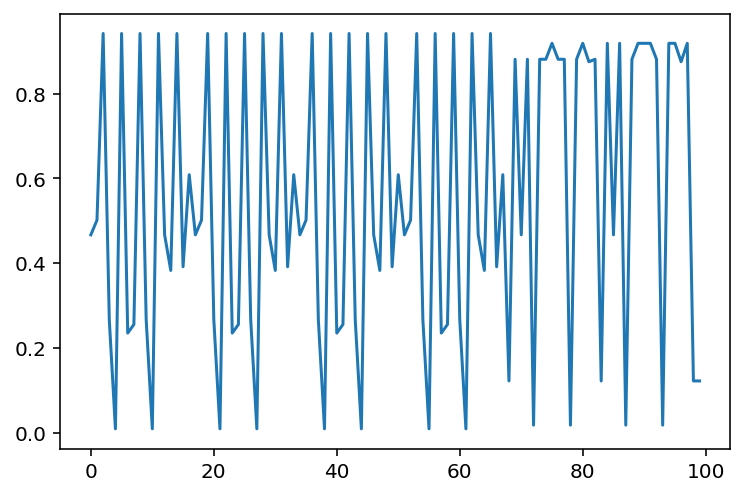

In [15]:
index=np.arange(sequence_length)
plt.plot(index,ins_train[0,:,0])

In [16]:
print(n_notes)

345


In [17]:
def build_model(lstm,hidden,dropout,l2,
                sequence_length=sequence_length,num_channels=1,activation='elu',num_notes=n_notes,verbose=1,
                lrate=0.001,optimizer='Adam'):
    
    num_LSTM_layers=len(lstm)
    num_hidden_layers=len(hidden)

    model = Sequential()
    model.add(InputLayer(input_shape=(sequence_length,num_channels)))
    model.add(LSTM(lstm[0],activation='elu',return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    if dropout!=0:
        model.add(Dropout(dropout))
    
    
    for i in range(1,num_LSTM_layers-1):
        model.add(LSTM(lstm[i],
                       activation=activation,
                       return_sequences=True,
                       kernel_regularizer=tf.keras.regularizers.l2(l2)))
        if dropout!=0:
            model.add(Dropout(dropout))
            
    model.add(LSTM(lstm[-1],
                   activation=activation,
                   return_sequences=False,
                   kernel_regularizer=tf.keras.regularizers.l2(l2)))
        
    for i in range(num_hidden_layers):
        
        model.add(Dense(units=hidden[i],
                        activation=activation,
                        use_bias=True,
                        kernel_initializer='truncated_normal',
                        bias_initializer='zeros',
                        name='D'+str(i),
                        kernel_regularizer=tf.keras.regularizers.l2(l2)))
        
        if dropout!=0:
            model.add(Dropout(dropout))
            
            
    model.add(Dense(num_notes,
                    activation='softmax'))
    if verbose>0:
        print(model.summary())
    
    if optimizer=='Adam':
        opt=tf.keras.optimizers.Adam(lr=lrate,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
    elif optimizer=='sgd':
        opt=tf.keras.optimizers.SGD(learning_rate=lrate, momentum=0.0, nesterov=False)
    else:
        opt='rmsprop'
    
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])
    
    return(model)

model=build_model(lstm=[128,256,128],hidden=[256],dropout=0.3,l2=0.0005,optimizer='sgd')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          66560     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 256)          394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
D0 (Dense)                   (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [19]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True,
                                                  min_delta=0.01)

In [ ]:
history=model.fit(ins_train, 
                  outs_train,
                  validation_data=(ins_validation, outs_validation),
                  epochs=10, 
                  batch_size=500,
                  callbacks=[early_stopping_cb])

Train on 24480 samples, validate on 6044 samples
Epoch 1/10
24480/24480 [==============================] - 107s 4ms/sample - loss: 6.1605 - categorical_accuracy: 0.0040 - val_loss: 6.1601 - val_categorical_accuracy: 0.0076
Epoch 2/10
14000/24480 [================>.............] - ETA: 44s - loss: 6.1597 - categorical_accuracy: 0.0073

In [82]:
history2=model.fit(ins_train, 
                  outs_train,
                  validation_data=(ins_validation, outs_validation),
                  epochs=10, 
                  batch_size=64,
                  callbacks=[early_stopping_cb])

Train on 21950 samples, validate on 8574 samples
Epoch 1/10
21950/21950 [==============================] - 163s 7ms/sample - loss: 6.1449 - categorical_accuracy: 0.0208 - val_loss: 6.1419 - val_categorical_accuracy: 0.0245
Epoch 2/10
21950/21950 [==============================] - 166s 8ms/sample - loss: 6.1367 - categorical_accuracy: 0.0213 - val_loss: 6.1343 - val_categorical_accuracy: 0.0245
Epoch 3/10
21950/21950 [==============================] - 172s 8ms/sample - loss: 6.1284 - categorical_accuracy: 0.0222 - val_loss: 6.1265 - val_categorical_accuracy: 0.0245
Epoch 4/10
21950/21950 [==============================] - 173s 8ms/sample - loss: 6.1199 - categorical_accuracy: 0.0205 - val_loss: 6.1185 - val_categorical_accuracy: 0.0245
Epoch 5/10
21950/21950 [==============================] - 177s 8ms/sample - loss: 6.1110 - categorical_accuracy: 0.0219 - val_loss: 6.1101 - val_categorical_accuracy: 0.0245
Epoch 6/10
21950/21950 [==============================] - 188s 9ms/sample - loss:

In [29]:
history3=model.fit(ins_train, 
                  outs_train,
                  validation_data=(ins_validation, outs_validation),
                  epochs=10, 
                  batch_size=500,
                  callbacks=[early_stopping_cb])

Train on 21269 samples, validate on 9255 samples
Epoch 1/10
21269/21269 [==============================] - 186s 9ms/sample - loss: 6.0477 - categorical_accuracy: 0.0313 - val_loss: 6.0648 - val_categorical_accuracy: 0.0260
Epoch 2/10
21269/21269 [==============================] - 197s 9ms/sample - loss: 6.0463 - categorical_accuracy: 0.0309 - val_loss: 6.0632 - val_categorical_accuracy: 0.0260
Epoch 3/10
21269/21269 [==============================] - 194s 9ms/sample - loss: 6.0435 - categorical_accuracy: 0.0310 - val_loss: 6.0614 - val_categorical_accuracy: 0.0260
Epoch 4/10
21269/21269 [==============================] - 185s 9ms/sample - loss: 6.0416 - categorical_accuracy: 0.0331 - val_loss: 6.0596 - val_categorical_accuracy: 0.0260
Epoch 5/10
21269/21269 [==============================] - 194s 9ms/sample - loss: 6.0394 - categorical_accuracy: 0.0309 - val_loss: 6.0578 - val_categorical_accuracy: 0.0260
Epoch 6/10
21269/21269 [==============================] - 200s 9ms/sample - loss:

In [ ]:
history4=model.fit(ins_train, 
                  outs_train,
                  validation_data=(ins_validation, outs_validation),
                  epochs=10, 
                  batch_size=64,
                  callbacks=[early_stopping_cb])

Train on 21269 samples, validate on 9255 samples
Epoch 1/10
21269/21269 [==============================] - 354s 17ms/sample - loss: 6.0163 - categorical_accuracy: 0.0311 - val_loss: 6.0301 - val_categorical_accuracy: 0.0260
Epoch 2/10
21269/21269 [==============================] - 353s 17ms/sample - loss: 5.9914 - categorical_accuracy: 0.0311 - val_loss: 6.0067 - val_categorical_accuracy: 0.0260
Epoch 3/10
21269/21269 [==============================] - 359s 17ms/sample - loss: 5.9591 - categorical_accuracy: 0.0329 - val_loss: 5.9741 - val_categorical_accuracy: 0.0260
Epoch 4/10
21248/21269 [============================>.] - ETA: 0s - loss: 5.9101 - categorical_accuracy: 0.0317

# It looks like a batch size of 64 works better than 500

# I wonder if it would be a good idea to cast a wide net at first, then pick the best model and train that one for much longer

# train 5 independent models for a short time, pick one model as best, then train that for a really long time

In [88]:
def combine_histories(histories):
    
    acc=[]
    val_acc=[]
    loss=[]
    val_loss=[]
    
    for i in histories:
        
        acc_temp=i.history['categorical_accuracy']
        val_acc_temp=i.history['val_categorical_accuracy']
        loss_temp=i.history['loss']
        val_loss_temp=i.history['val_loss']
        
        acc.extend(acc_temp)
        val_acc.extend(val_acc_temp)
        loss.extend(loss_temp)
        val_loss.extend(val_loss_temp)
        
        
    history_combined={'categorical_accuracy':acc,'val_categorical_accuracy':val_acc,'loss':loss,'val_loss':val_loss}
    return history_combined
        
histories=[history,history2]
history_comb=combine_histories(histories)

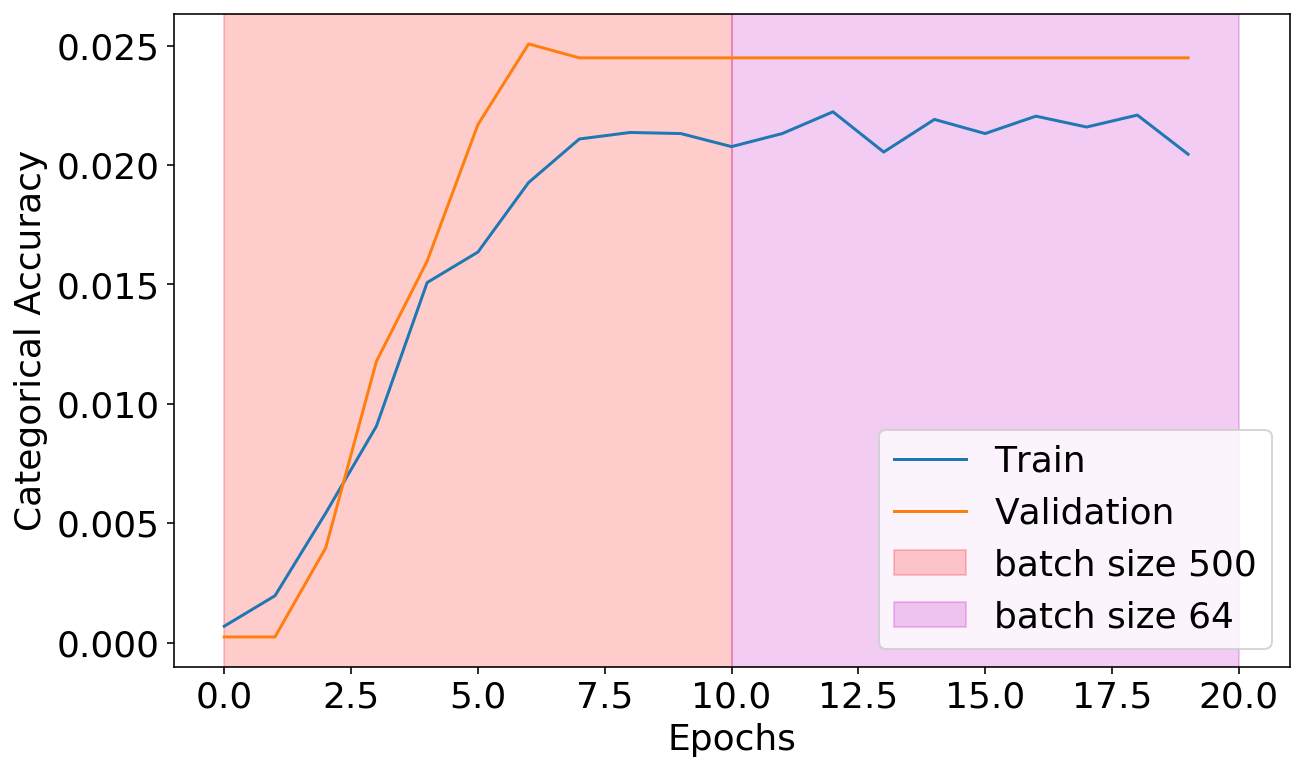

In [101]:
epochs=np.arange(len(history_comb['loss']))

plt.plot(epochs,history_comb['categorical_accuracy'],label='Train')
plt.plot(epochs,history_comb['val_categorical_accuracy'],label='Validation')
plt.axvspan(0,10,alpha=0.2,color='r',label='batch size 500')
plt.axvspan(10,20,alpha=0.2,color='m',label='batch size 64')
#plt.axvspan(20,30,alpha=0.2,color='r')
#plt.axvspan(30,40,alpha=0.2,color='m')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend(loc='best')
plt.show()

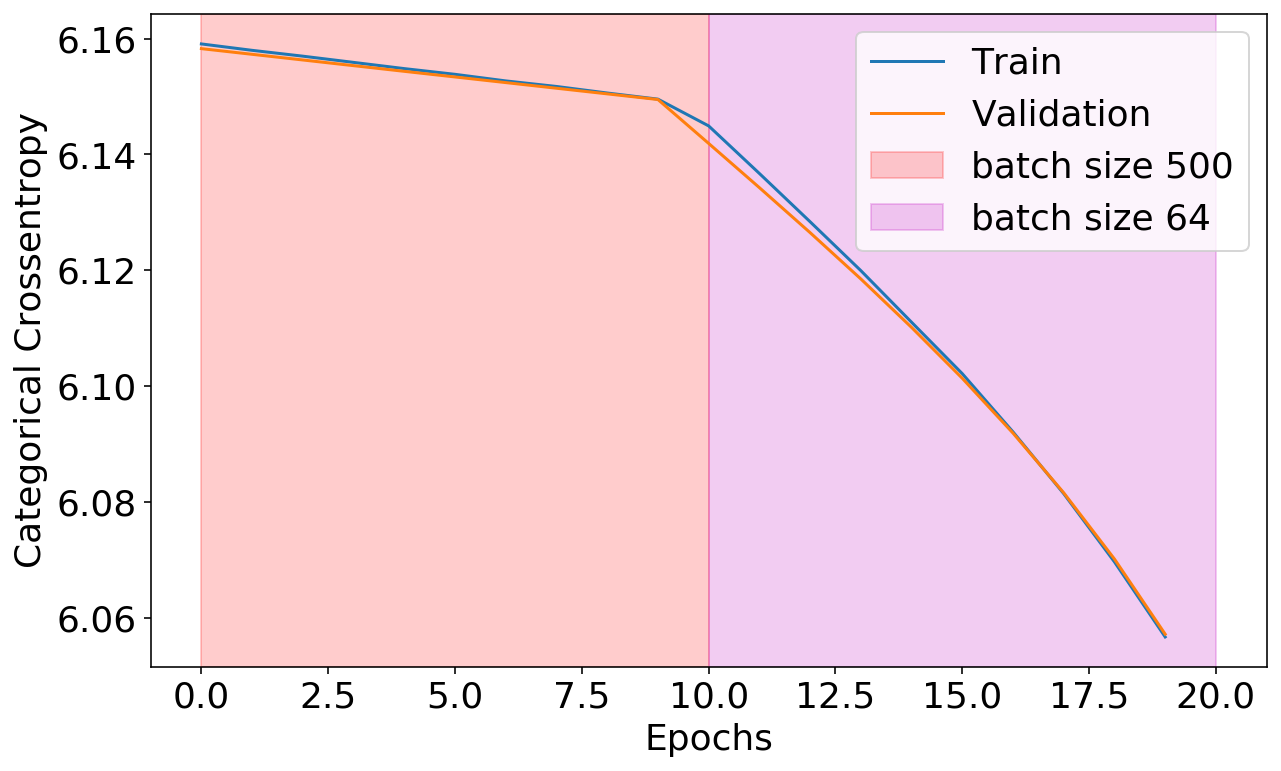

In [102]:
plt.plot(epochs,history_comb['loss'],label='Train')
plt.plot(epochs,history_comb['val_loss'],label='Validation')
plt.axvspan(0,10,alpha=0.2,color='r',label='batch size 500')
plt.axvspan(10,20,alpha=0.2,color='m',label='batch size 64')
#plt.axvspan(20,30,alpha=0.2,color='r')
#plt.axvspan(30,40,alpha=0.2,color='m')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.legend(loc='best')
plt.show()